   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality   type  
0      8.8        6  white  
1      9.5        6  white  

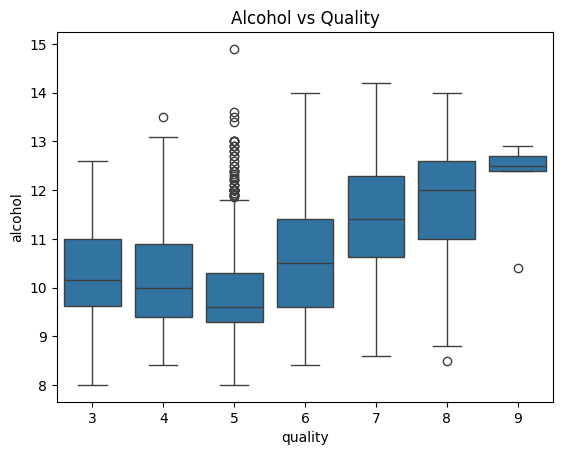

Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64
No missing values found in the dataset.


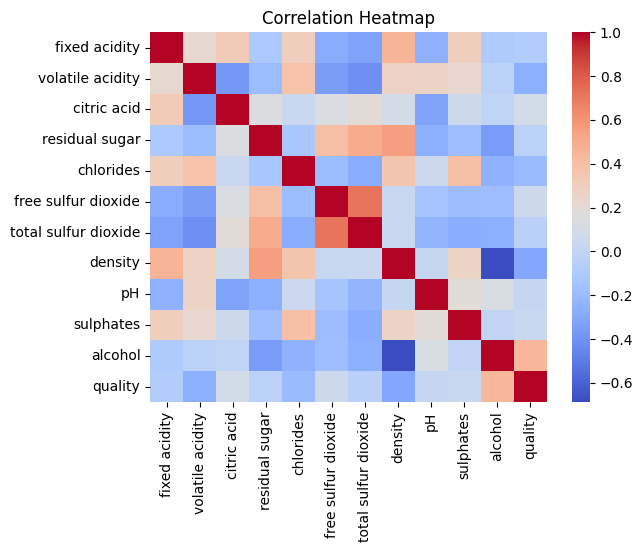

Best RF params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Linear Regression
MAE : 0.5756847201823087
RMSE: 0.7302443201081898
R²  : 0.3217625544762871
Decision Tree
MAE : 0.49538461538461537
RMSE: 0.8384968235341879
R²  : 0.10577206745618428
Random Forest (Best)
MAE : 0.4360346153846154
RMSE: 0.6068242522155184
R²  : 0.5316492209936603


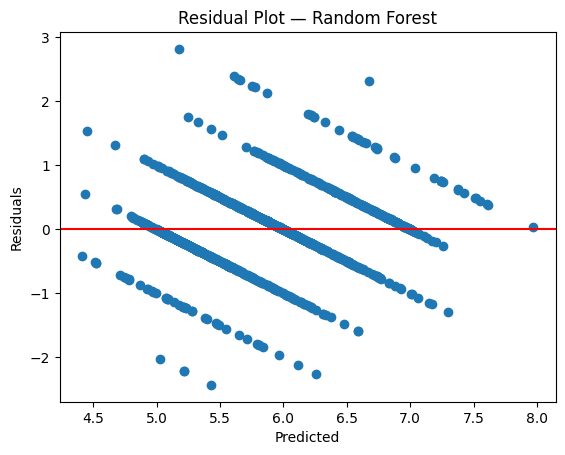

Logistic Regression (Classification)
Accuracy: 0.9930769230769231
              precision    recall  f1-score   support

         red       0.99      0.98      0.99       320
       white       0.99      1.00      1.00       980

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300

Random Forest (Classification)
Accuracy: 0.9946153846153846
              precision    recall  f1-score   support

         red       0.99      0.98      0.99       320
       white       0.99      1.00      1.00       980

    accuracy                           0.99      1300
   macro avg       0.99      0.99      0.99      1300
weighted avg       0.99      0.99      0.99      1300



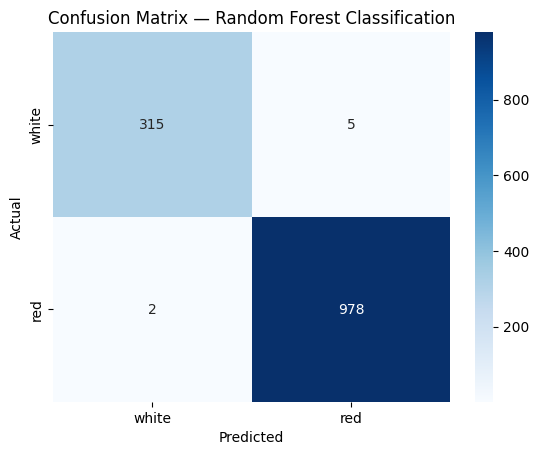

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
)

# Load Data
white = pd.read_csv("winequality-white.csv", sep=";")
red = pd.read_csv("winequality-red.csv", sep=";")

white["type"] = "white"
red["type"] = "red"

df = pd.concat([white, red], ignore_index=True)
df["type"] = df["type"].astype("category")

print(df.head())
print(df.info())

# EDA
sns.boxplot(x="quality", y="alcohol", data=df)
plt.title("Alcohol vs Quality")
plt.show()

# Missing Value Check
missing = df.isna().sum()
print("Missing values per column:")
print(missing)

if missing.sum() == 0:
    print("No missing values found in the dataset.")
else:
    print("Missing values detected!")

sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Regression Setup
X = df.drop(["quality"], axis=1)
y = df["quality"]

numeric_features = X.drop(columns=["type"]).select_dtypes(include=[np.number]).columns
categorical_features = ["type"]

preprocessor_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first"), categorical_features),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

# Linear Regression
lin_model = Pipeline([
    ("prep", preprocessor_reg),
    ("model", LinearRegression())
])
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

tree_model = Pipeline([
    ("prep", preprocessor_reg),
    ("model", DecisionTreeRegressor(random_state=1))
])
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

rf_pipeline = Pipeline([
    ("prep", preprocessor_reg),
    ("model", RandomForestRegressor(random_state=1))
])

param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 10]
}

grid = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("Best RF params:", grid.best_params_)

def evaluate_reg(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)

    print(f"{name}")
    print("MAE :", mae)
    print("RMSE:", rmse)
    print("R²  :", r2)

evaluate_reg(y_test, y_pred_lin, "Linear Regression")
evaluate_reg(y_test, y_pred_tree, "Decision Tree")
evaluate_reg(y_test, y_pred_rf, "Random Forest (Best)")

residuals = y_test - y_pred_rf
plt.scatter(y_pred_rf, residuals)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot — Random Forest")
plt.show()

# Classification Setup
X_clf = df.drop("type", axis=1)
y_clf = df["type"]

numeric_features_clf = X_clf.columns
preprocessor_clf = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_clf)
    ]
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=1, stratify=y_clf
)

logreg_model = Pipeline([
    ("prep", preprocessor_clf),
    ("model", LogisticRegression(max_iter=500, random_state=1))
])
logreg_model.fit(X_train_clf, y_train_clf)
y_pred_log = logreg_model.predict(X_test_clf)

print("Logistic Regression (Classification)")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_log))
print(classification_report(y_test_clf, y_pred_log))

rf_clf = Pipeline([
    ("prep", preprocessor_clf),
    ("model", RandomForestClassifier(random_state=1))
])
rf_clf.fit(X_train_clf, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test_clf)

print("Random Forest (Classification)")
print("Accuracy:", accuracy_score(y_test_clf, y_pred_rf_clf))
print(classification_report(y_test_clf, y_pred_rf_clf))

cm = confusion_matrix(y_test_clf, y_pred_rf_clf)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["white", "red"],
            yticklabels=["white", "red"])
plt.title("Confusion Matrix — Random Forest Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()